# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

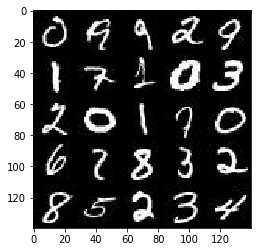

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

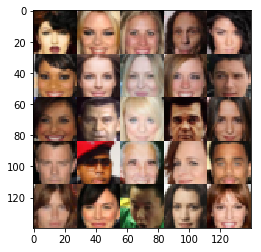

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_height, image_width, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
# define leaky_relu
def leaky_relu(x, alpha=0.1):
    return tf.maximum(x, alpha * x)

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        conv_1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu_1 = leaky_relu(conv_1)
        
        conv_2 = tf.layers.conv2d(relu_1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn_2 = tf.layers.batch_normalization(conv_2, training=True)
        relu_2 = leaky_relu(bn_2)
        
        flatten = tf.reshape(relu_2, (-1, 7*7*128))
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        ly_1 = tf.layers.dense(z, 7*7*512)
        
        ly_1 = tf.reshape(ly_1, (-1, 7, 7, 512))
        ly_1 = tf.layers.batch_normalization(ly_1, training=is_train)
        ly_1 = leaky_relu(ly_1)
        
        ly_2 = tf.layers.conv2d_transpose(ly_1, 64, 5, strides=2, padding='same')
        ly_2 = tf.layers.batch_normalization(ly_2, training=is_train)
        ly_2 = leaky_relu(ly_2)
        
        logits = tf.layers.conv2d_transpose(ly_2, out_channel_dim, 5, strides=2, padding='same')
        out =tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth=0.1
    
    gener = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(gener, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    d_vars = [var for var in tf.trainable_variables() if var.name.startswith('discriminator')]
    g_vars = [var for var in tf.trainable_variables() if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    count = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                count += 1
                
                batch_images *= 2 # normalization
                
                n_images=len(batch_images)
                batch_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
                
                sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if count%10 == 0:
                    d_train_loss = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    g_train_loss = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i, epoch_count-1),
                          "Discriminator Loss: {:.4f}...".format(d_train_loss), "Generator Loss: {:.4f}".format(g_train_loss))
                if count%128 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
        
        show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/1... Discriminator Loss: 1.8161... Generator Loss: 0.3989
Epoch 0/1... Discriminator Loss: 2.1616... Generator Loss: 0.3059
Epoch 0/1... Discriminator Loss: 1.2540... Generator Loss: 0.8668
Epoch 0/1... Discriminator Loss: 1.3131... Generator Loss: 0.7144
Epoch 0/1... Discriminator Loss: 1.0805... Generator Loss: 0.8791
Epoch 0/1... Discriminator Loss: 1.7324... Generator Loss: 0.3043
Epoch 0/1... Discriminator Loss: 1.2895... Generator Loss: 1.7910
Epoch 0/1... Discriminator Loss: 1.3519... Generator Loss: 0.5323
Epoch 0/1... Discriminator Loss: 1.1132... Generator Loss: 1.1047
Epoch 0/1... Discriminator Loss: 1.0858... Generator Loss: 0.8693
Epoch 0/1... Discriminator Loss: 1.1697... Generator Loss: 0.6899
Epoch 0/1... Discriminator Loss: 1.0615... Generator Loss: 0.9515


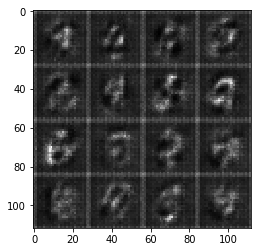

Epoch 0/1... Discriminator Loss: 1.0389... Generator Loss: 1.1036
Epoch 0/1... Discriminator Loss: 1.1459... Generator Loss: 1.4632
Epoch 0/1... Discriminator Loss: 1.1541... Generator Loss: 0.6952
Epoch 0/1... Discriminator Loss: 1.0178... Generator Loss: 1.1258
Epoch 0/1... Discriminator Loss: 1.1031... Generator Loss: 0.8063
Epoch 0/1... Discriminator Loss: 1.1890... Generator Loss: 1.8285
Epoch 0/1... Discriminator Loss: 1.0612... Generator Loss: 0.9061
Epoch 0/1... Discriminator Loss: 0.9828... Generator Loss: 1.1429
Epoch 0/1... Discriminator Loss: 1.0171... Generator Loss: 1.1394
Epoch 0/1... Discriminator Loss: 1.1074... Generator Loss: 1.4837
Epoch 0/1... Discriminator Loss: 0.9922... Generator Loss: 1.0111
Epoch 0/1... Discriminator Loss: 1.0739... Generator Loss: 0.7603
Epoch 0/1... Discriminator Loss: 1.0358... Generator Loss: 0.9137


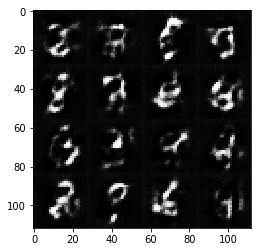

Epoch 0/1... Discriminator Loss: 1.0606... Generator Loss: 0.7938
Epoch 0/1... Discriminator Loss: 1.2365... Generator Loss: 0.5654
Epoch 0/1... Discriminator Loss: 1.0766... Generator Loss: 0.7837
Epoch 0/1... Discriminator Loss: 1.0037... Generator Loss: 1.3426
Epoch 0/1... Discriminator Loss: 0.9869... Generator Loss: 1.0636
Epoch 0/1... Discriminator Loss: 0.9871... Generator Loss: 1.4769
Epoch 0/1... Discriminator Loss: 1.1270... Generator Loss: 1.8231
Epoch 0/1... Discriminator Loss: 1.0192... Generator Loss: 1.1652
Epoch 0/1... Discriminator Loss: 1.0045... Generator Loss: 1.0012
Epoch 0/1... Discriminator Loss: 1.0674... Generator Loss: 1.4261
Epoch 0/1... Discriminator Loss: 0.9942... Generator Loss: 1.3804
Epoch 0/1... Discriminator Loss: 1.1755... Generator Loss: 0.6843
Epoch 0/1... Discriminator Loss: 1.0307... Generator Loss: 1.2144


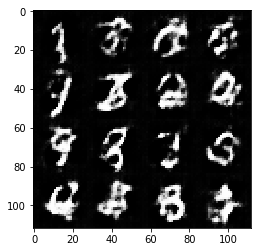

Epoch 0/1... Discriminator Loss: 1.0445... Generator Loss: 1.6264
Epoch 0/1... Discriminator Loss: 1.0814... Generator Loss: 0.8786
Epoch 0/1... Discriminator Loss: 1.3259... Generator Loss: 0.5108
Epoch 0/1... Discriminator Loss: 1.0545... Generator Loss: 1.0777
Epoch 0/1... Discriminator Loss: 1.0642... Generator Loss: 1.5027
Epoch 0/1... Discriminator Loss: 1.0024... Generator Loss: 1.2486
Epoch 0/1... Discriminator Loss: 1.0993... Generator Loss: 1.2546
Epoch 0/1... Discriminator Loss: 0.9921... Generator Loss: 1.0733
Epoch 1/1... Discriminator Loss: 1.0568... Generator Loss: 1.4796
Epoch 1/1... Discriminator Loss: 1.0500... Generator Loss: 1.0614
Epoch 1/1... Discriminator Loss: 1.1637... Generator Loss: 1.6014
Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 1.3214
Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 0.7481


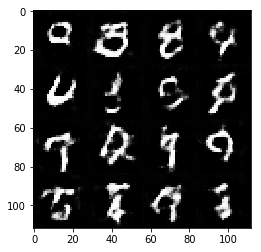

Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 1.1072
Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 0.9699
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 1.2466
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.5440
Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 0.8991
Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.4994
Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 1.0535
Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.0928... Generator Loss: 1.4936
Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 1.4023
Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 1.4058
Epoch 1/1... Discriminator Loss: 1.0568... Generator Loss: 1.1202


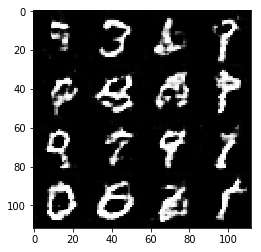

Epoch 1/1... Discriminator Loss: 2.3549... Generator Loss: 3.0468
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 0.9921
Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 1.0001
Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 0.9916
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.5158
Epoch 1/1... Discriminator Loss: 1.0592... Generator Loss: 1.1503
Epoch 1/1... Discriminator Loss: 1.0636... Generator Loss: 1.1594
Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 1.1280
Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 0.8675
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 1.0560
Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 0.9950
Epoch 1/1... Discriminator Loss: 1.0848... Generator Loss: 0.9577


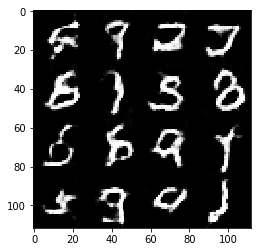

Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 0.8737
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 1.8547
Epoch 1/1... Discriminator Loss: 1.0244... Generator Loss: 1.0252
Epoch 1/1... Discriminator Loss: 1.0524... Generator Loss: 1.2854
Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 0.5508
Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 0.9959
Epoch 1/1... Discriminator Loss: 1.0454... Generator Loss: 1.5302
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.5659
Epoch 1/1... Discriminator Loss: 1.0865... Generator Loss: 0.8245
Epoch 1/1... Discriminator Loss: 1.0103... Generator Loss: 1.0408
Epoch 1/1... Discriminator Loss: 1.1024... Generator Loss: 0.9457
Epoch 1/1... Discriminator Loss: 1.0807... Generator Loss: 1.4722
Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 0.8168


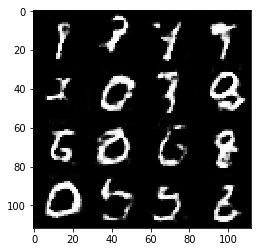

Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 1.7013
Epoch 1/1... Discriminator Loss: 1.0875... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.0695... Generator Loss: 1.2869


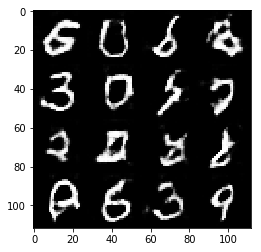

In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/0... Discriminator Loss: 2.8256... Generator Loss: 0.1315
Epoch 0/0... Discriminator Loss: 2.4708... Generator Loss: 0.2716
Epoch 0/0... Discriminator Loss: 1.7733... Generator Loss: 0.6102
Epoch 0/0... Discriminator Loss: 1.4751... Generator Loss: 0.7976
Epoch 0/0... Discriminator Loss: 1.2877... Generator Loss: 0.9569
Epoch 0/0... Discriminator Loss: 1.2918... Generator Loss: 0.8873
Epoch 0/0... Discriminator Loss: 1.3733... Generator Loss: 0.9529
Epoch 0/0... Discriminator Loss: 1.3545... Generator Loss: 0.9094
Epoch 0/0... Discriminator Loss: 1.3812... Generator Loss: 0.9293
Epoch 0/0... Discriminator Loss: 1.2741... Generator Loss: 1.0043
Epoch 0/0... Discriminator Loss: 1.3296... Generator Loss: 0.7400
Epoch 0/0... Discriminator Loss: 1.3070... Generator Loss: 0.8199


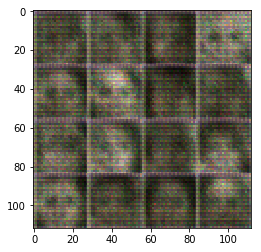

Epoch 0/0... Discriminator Loss: 1.3564... Generator Loss: 0.7628
Epoch 0/0... Discriminator Loss: 1.4071... Generator Loss: 0.7695
Epoch 0/0... Discriminator Loss: 1.5134... Generator Loss: 0.6447
Epoch 0/0... Discriminator Loss: 1.4290... Generator Loss: 0.8470
Epoch 0/0... Discriminator Loss: 1.3920... Generator Loss: 0.7478
Epoch 0/0... Discriminator Loss: 1.4285... Generator Loss: 0.6388
Epoch 0/0... Discriminator Loss: 1.3498... Generator Loss: 0.9263
Epoch 0/0... Discriminator Loss: 1.4683... Generator Loss: 1.2794
Epoch 0/0... Discriminator Loss: 1.3727... Generator Loss: 0.5941
Epoch 0/0... Discriminator Loss: 1.1594... Generator Loss: 0.9566
Epoch 0/0... Discriminator Loss: 1.5248... Generator Loss: 0.5999
Epoch 0/0... Discriminator Loss: 1.3694... Generator Loss: 0.7925
Epoch 0/0... Discriminator Loss: 1.3663... Generator Loss: 0.8366


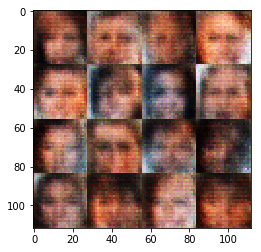

Epoch 0/0... Discriminator Loss: 1.3385... Generator Loss: 0.8620
Epoch 0/0... Discriminator Loss: 1.3233... Generator Loss: 0.7601
Epoch 0/0... Discriminator Loss: 1.2884... Generator Loss: 0.8839
Epoch 0/0... Discriminator Loss: 1.3707... Generator Loss: 0.6897
Epoch 0/0... Discriminator Loss: 1.2005... Generator Loss: 0.9922
Epoch 0/0... Discriminator Loss: 1.2960... Generator Loss: 0.9106
Epoch 0/0... Discriminator Loss: 1.3241... Generator Loss: 0.7956
Epoch 0/0... Discriminator Loss: 1.2929... Generator Loss: 1.1358
Epoch 0/0... Discriminator Loss: 1.3155... Generator Loss: 0.8179
Epoch 0/0... Discriminator Loss: 1.2918... Generator Loss: 0.8584
Epoch 0/0... Discriminator Loss: 1.2824... Generator Loss: 1.5640
Epoch 0/0... Discriminator Loss: 1.2330... Generator Loss: 0.8105
Epoch 0/0... Discriminator Loss: 1.2213... Generator Loss: 0.9844


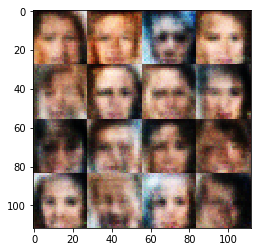

Epoch 0/0... Discriminator Loss: 1.2788... Generator Loss: 0.9830
Epoch 0/0... Discriminator Loss: 1.1248... Generator Loss: 0.9660
Epoch 0/0... Discriminator Loss: 1.2844... Generator Loss: 0.7836
Epoch 0/0... Discriminator Loss: 1.3530... Generator Loss: 0.8087
Epoch 0/0... Discriminator Loss: 1.3867... Generator Loss: 0.7406
Epoch 0/0... Discriminator Loss: 1.1842... Generator Loss: 0.7729
Epoch 0/0... Discriminator Loss: 1.4259... Generator Loss: 0.5944
Epoch 0/0... Discriminator Loss: 1.3945... Generator Loss: 0.7145
Epoch 0/0... Discriminator Loss: 1.3147... Generator Loss: 0.6674
Epoch 0/0... Discriminator Loss: 1.3586... Generator Loss: 1.0728
Epoch 0/0... Discriminator Loss: 1.3264... Generator Loss: 1.1332
Epoch 0/0... Discriminator Loss: 1.2108... Generator Loss: 1.2106
Epoch 0/0... Discriminator Loss: 1.2477... Generator Loss: 0.8959


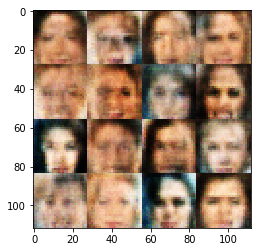

Epoch 0/0... Discriminator Loss: 1.2234... Generator Loss: 0.9858
Epoch 0/0... Discriminator Loss: 1.2520... Generator Loss: 1.0992
Epoch 0/0... Discriminator Loss: 1.2728... Generator Loss: 0.8734
Epoch 0/0... Discriminator Loss: 1.2010... Generator Loss: 1.1809
Epoch 0/0... Discriminator Loss: 1.2818... Generator Loss: 0.9307
Epoch 0/0... Discriminator Loss: 1.3616... Generator Loss: 0.7071
Epoch 0/0... Discriminator Loss: 1.2279... Generator Loss: 0.9055
Epoch 0/0... Discriminator Loss: 1.1648... Generator Loss: 1.0013
Epoch 0/0... Discriminator Loss: 1.2630... Generator Loss: 0.7868
Epoch 0/0... Discriminator Loss: 1.3040... Generator Loss: 0.8092
Epoch 0/0... Discriminator Loss: 1.3539... Generator Loss: 0.7036
Epoch 0/0... Discriminator Loss: 1.4150... Generator Loss: 0.7225
Epoch 0/0... Discriminator Loss: 1.4458... Generator Loss: 0.6224


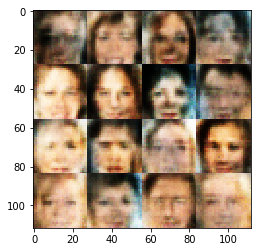

Epoch 0/0... Discriminator Loss: 1.4002... Generator Loss: 0.9332
Epoch 0/0... Discriminator Loss: 1.3143... Generator Loss: 1.1419
Epoch 0/0... Discriminator Loss: 1.4679... Generator Loss: 0.9964
Epoch 0/0... Discriminator Loss: 1.3449... Generator Loss: 0.7358
Epoch 0/0... Discriminator Loss: 1.2600... Generator Loss: 0.8750
Epoch 0/0... Discriminator Loss: 1.3676... Generator Loss: 0.9686
Epoch 0/0... Discriminator Loss: 1.3073... Generator Loss: 1.0554
Epoch 0/0... Discriminator Loss: 1.6021... Generator Loss: 0.6724
Epoch 0/0... Discriminator Loss: 1.6940... Generator Loss: 0.9035
Epoch 0/0... Discriminator Loss: 1.7559... Generator Loss: 0.6876
Epoch 0/0... Discriminator Loss: 1.4631... Generator Loss: 0.6064
Epoch 0/0... Discriminator Loss: 1.3636... Generator Loss: 0.9119


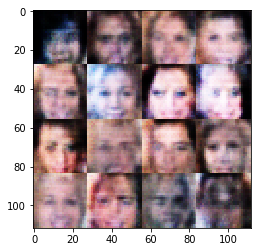

Epoch 0/0... Discriminator Loss: 1.2709... Generator Loss: 0.8292
Epoch 0/0... Discriminator Loss: 1.4857... Generator Loss: 0.6572
Epoch 0/0... Discriminator Loss: 1.3631... Generator Loss: 0.9286
Epoch 0/0... Discriminator Loss: 1.4000... Generator Loss: 0.7334
Epoch 0/0... Discriminator Loss: 1.3856... Generator Loss: 0.9412
Epoch 0/0... Discriminator Loss: 1.4126... Generator Loss: 0.7603
Epoch 0/0... Discriminator Loss: 1.4075... Generator Loss: 0.9141
Epoch 0/0... Discriminator Loss: 1.4321... Generator Loss: 0.7671
Epoch 0/0... Discriminator Loss: 1.3308... Generator Loss: 0.8446
Epoch 0/0... Discriminator Loss: 1.4404... Generator Loss: 0.7455
Epoch 0/0... Discriminator Loss: 1.5239... Generator Loss: 0.7711
Epoch 0/0... Discriminator Loss: 1.3831... Generator Loss: 0.7012
Epoch 0/0... Discriminator Loss: 1.4194... Generator Loss: 0.8068


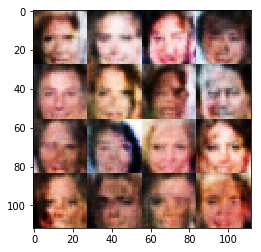

Epoch 0/0... Discriminator Loss: 1.3877... Generator Loss: 0.8483
Epoch 0/0... Discriminator Loss: 1.4176... Generator Loss: 0.9073
Epoch 0/0... Discriminator Loss: 1.3141... Generator Loss: 0.8025
Epoch 0/0... Discriminator Loss: 1.5807... Generator Loss: 0.6483
Epoch 0/0... Discriminator Loss: 1.4081... Generator Loss: 0.8652
Epoch 0/0... Discriminator Loss: 1.3639... Generator Loss: 0.9152
Epoch 0/0... Discriminator Loss: 1.4991... Generator Loss: 0.7457
Epoch 0/0... Discriminator Loss: 1.4193... Generator Loss: 0.9891
Epoch 0/0... Discriminator Loss: 1.3638... Generator Loss: 0.8403
Epoch 0/0... Discriminator Loss: 1.4293... Generator Loss: 0.7408
Epoch 0/0... Discriminator Loss: 1.4212... Generator Loss: 0.8369
Epoch 0/0... Discriminator Loss: 1.4233... Generator Loss: 1.1210
Epoch 0/0... Discriminator Loss: 1.3644... Generator Loss: 0.8015


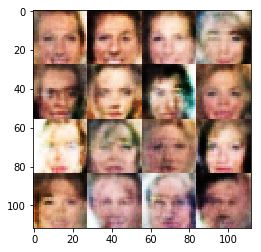

Epoch 0/0... Discriminator Loss: 1.4943... Generator Loss: 0.6558
Epoch 0/0... Discriminator Loss: 1.3426... Generator Loss: 0.8712
Epoch 0/0... Discriminator Loss: 1.4482... Generator Loss: 0.7714
Epoch 0/0... Discriminator Loss: 1.3212... Generator Loss: 0.8150
Epoch 0/0... Discriminator Loss: 1.3488... Generator Loss: 0.8287
Epoch 0/0... Discriminator Loss: 1.4140... Generator Loss: 0.7264
Epoch 0/0... Discriminator Loss: 1.3586... Generator Loss: 0.8835
Epoch 0/0... Discriminator Loss: 1.3985... Generator Loss: 0.7624
Epoch 0/0... Discriminator Loss: 1.4421... Generator Loss: 0.7298
Epoch 0/0... Discriminator Loss: 1.4708... Generator Loss: 0.6747
Epoch 0/0... Discriminator Loss: 1.3398... Generator Loss: 0.8886
Epoch 0/0... Discriminator Loss: 1.4634... Generator Loss: 0.6950
Epoch 0/0... Discriminator Loss: 1.3588... Generator Loss: 0.7379


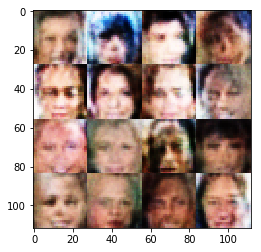

Epoch 0/0... Discriminator Loss: 1.4569... Generator Loss: 0.8029
Epoch 0/0... Discriminator Loss: 1.3521... Generator Loss: 0.7766
Epoch 0/0... Discriminator Loss: 1.4068... Generator Loss: 0.8074
Epoch 0/0... Discriminator Loss: 1.4198... Generator Loss: 0.7526
Epoch 0/0... Discriminator Loss: 1.3788... Generator Loss: 0.8043
Epoch 0/0... Discriminator Loss: 1.4134... Generator Loss: 0.8810
Epoch 0/0... Discriminator Loss: 1.2864... Generator Loss: 0.9542
Epoch 0/0... Discriminator Loss: 1.3766... Generator Loss: 0.7774
Epoch 0/0... Discriminator Loss: 1.3614... Generator Loss: 0.8922
Epoch 0/0... Discriminator Loss: 1.2744... Generator Loss: 0.9176
Epoch 0/0... Discriminator Loss: 1.4367... Generator Loss: 0.6440
Epoch 0/0... Discriminator Loss: 1.3272... Generator Loss: 0.8399
Epoch 0/0... Discriminator Loss: 1.4308... Generator Loss: 0.7713


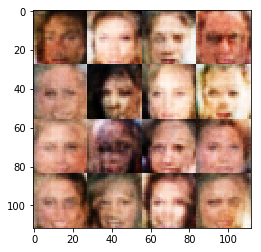

Epoch 0/0... Discriminator Loss: 1.4188... Generator Loss: 0.6447
Epoch 0/0... Discriminator Loss: 1.4447... Generator Loss: 0.6479
Epoch 0/0... Discriminator Loss: 1.4139... Generator Loss: 1.1193
Epoch 0/0... Discriminator Loss: 1.4309... Generator Loss: 0.6948
Epoch 0/0... Discriminator Loss: 1.4077... Generator Loss: 0.8085
Epoch 0/0... Discriminator Loss: 1.4288... Generator Loss: 0.7489
Epoch 0/0... Discriminator Loss: 1.4035... Generator Loss: 0.7902
Epoch 0/0... Discriminator Loss: 1.4004... Generator Loss: 0.7831
Epoch 0/0... Discriminator Loss: 1.4148... Generator Loss: 0.8516
Epoch 0/0... Discriminator Loss: 1.3575... Generator Loss: 0.8768
Epoch 0/0... Discriminator Loss: 1.4204... Generator Loss: 0.6459
Epoch 0/0... Discriminator Loss: 1.4439... Generator Loss: 0.8389


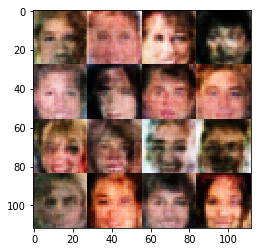

Epoch 0/0... Discriminator Loss: 1.4429... Generator Loss: 0.7927
Epoch 0/0... Discriminator Loss: 1.3206... Generator Loss: 0.8378
Epoch 0/0... Discriminator Loss: 1.3800... Generator Loss: 0.8322
Epoch 0/0... Discriminator Loss: 1.1858... Generator Loss: 0.9860
Epoch 0/0... Discriminator Loss: 1.4869... Generator Loss: 0.6376
Epoch 0/0... Discriminator Loss: 1.4069... Generator Loss: 0.9573
Epoch 0/0... Discriminator Loss: 1.3007... Generator Loss: 0.9836
Epoch 0/0... Discriminator Loss: 1.4079... Generator Loss: 0.7909
Epoch 0/0... Discriminator Loss: 1.3170... Generator Loss: 0.8511
Epoch 0/0... Discriminator Loss: 1.4031... Generator Loss: 0.7575
Epoch 0/0... Discriminator Loss: 1.2676... Generator Loss: 1.1240
Epoch 0/0... Discriminator Loss: 1.4203... Generator Loss: 0.7982
Epoch 0/0... Discriminator Loss: 1.2973... Generator Loss: 0.9838


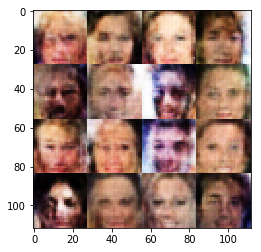

Epoch 0/0... Discriminator Loss: 1.4740... Generator Loss: 0.7369
Epoch 0/0... Discriminator Loss: 1.3774... Generator Loss: 0.7460
Epoch 0/0... Discriminator Loss: 1.3067... Generator Loss: 0.9340
Epoch 0/0... Discriminator Loss: 1.3059... Generator Loss: 0.8669
Epoch 0/0... Discriminator Loss: 1.3628... Generator Loss: 0.8229


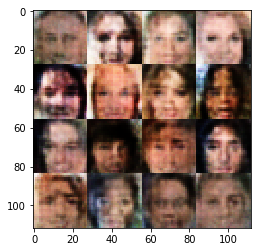

In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.